In [1]:
import glob
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/ref/cnp.ckpt"

# ConditionalNeuralProcess

In [3]:
import tensorflow as tf

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.13.1'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

from neuralprocesses.np.cnp import ConditionalNeuralProcess


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Basic example

In [6]:
tf.reset_default_graph()
tf.set_random_seed(2019)

In [7]:
BATCH_SIZE = 32

In [8]:
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
process = GaussianProcess(squared_exponential_kernel)
data_provider = DataProvider(process, batch_size=BATCH_SIZE, plot_settings={"num_context": 5})

In [9]:
data = data_provider(plotting_mode=plotting_mode)
cnp = ConditionalNeuralProcess(name="CNP")

In [10]:
mean, variance, loss = cnp(data)

In [11]:
with tf.variable_scope("trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(loss)

In [12]:
with tf.variable_scope("plot"):
    x_context = data.queries[0][0][0]
    y_context = data.queries[0][1][0]
    x_target = data.queries[1][0]
    plot_context = tf_sort_by_col(tf.stack([x_context, y_context], axis=1), 0)
    plot_predictions_mean = tf_sort_by_col(tf.stack([x_target, mean[0]], axis=1), 0)
    plot_predictions_max = tf_sort_by_col(tf.stack([x_target, mean[0] + tf.sqrt(variance[0])], axis=1), 0)
    plot_predictions_min = tf_sort_by_col(tf.stack([x_target, mean[0] - tf.sqrt(variance[0])], axis=1), 0)

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Train the CNP model:

In [14]:
from tqdm import tqdm

100%|██████████| 100000/100000 [07:47<00:00, 176.98it/s]


Model saved in: ../storage/ref/cnp.ckpt


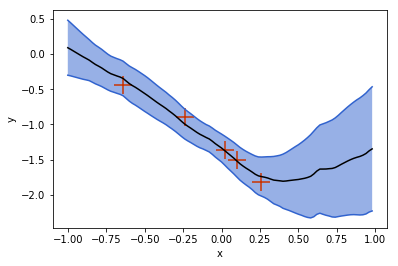

In [15]:
NUM_EPISODES = 100000
SAVE_STEP = 10000

with tf.Session() as session:
    
    # Check if we already ran this code
    if len(glob.glob(SAVE_PATH + "*")) > 0:
        # Restore weights and settings from past run
        print(f"Restoring model from: {SAVE_PATH}")
        saver.restore(session, SAVE_PATH)
    else:    
        # Initialize variables
        init = tf.global_variables_initializer()
        saver = tf.train.Saver(
            tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="CNP"), 
            max_to_keep=4, 
            keep_checkpoint_every_n_hours=1
        )
        session.run(init)

        # Do training
        for episode in tqdm(range(NUM_EPISODES)):
            session.run(training_step, feed_dict={plotting_mode: False})
            
            if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
                saver.save(session, SAVE_PATH, global_step=episode)
    
        # Save resulting graph
        print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

    # Compute a test case for plotting
    ctxt, xy, xymax, xymin = session.run([
        plot_context, plot_predictions_mean, 
        plot_predictions_max, plot_predictions_min],
        feed_dict={plotting_mode: True}
    )
    
    # Plot the result
    list_plot([xy, xymin, xymax, ctxt],
          joined=[True,True,True,False], 
          mesh=[False,False,False,True],
          plot_style=[
              # Mean in black
              Color((0,0,0)),  
              # Confidence interval bounds in blue
              Color.color_data(n=1),
              Color.color_data(n=1),
              # Context points as Red crosses
              {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300}
          ],
          axes_label=("x", "y"),
          filling=[[1,2]]
    )

Run the trained model with your favourite context points:

In [16]:
from neuralprocesses.np.aux import RegressionInput

In [17]:
import numpy as np

In [18]:
def predict(xc, yc):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        xt = np.arange(-1., 1.01, 0.01)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run([
            plot_context, plot_predictions_mean, 
            plot_predictions_max, plot_predictions_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )

        # Plot the result
        list_plot([xy, xymin, xymax, ctxt],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in black
                  Color((0,0,0)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300}
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )

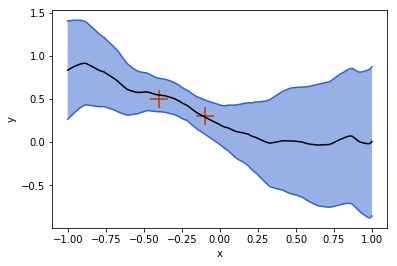

In [19]:
predict([-0.4, -0.1], [0.5, 0.3])